# Guruprasad Velikadu Krishnamoorthy
# DSC530- Assignment Week 11

## Initial Setup

In [1]:
# Download basename and exists from OS module which will be used in the download function
from os.path import basename, exists

# Create a function named download_file, to dounload the scripts and files from Github to local path
def download_files(url):
    """
    Downloads the scripts/ files from Github to local directory
    takes url as input.
    """
    filename = basename(url)
    # Checking if the file exists in the local directory and it downloads the file if it doesn't exist already.
    if not exists(filename):
        from urllib.request import urlretrieve
        # Downloading the files to the local path
        local, _ = urlretrieve(url, filename)
        # Printing confirmation message
        print("Downloaded " + local)

In [2]:
#  Calling download functions to download .py files and data files used throughtout this assignment
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")

In [3]:
# Importing the nsfg and other modules module from the author's code
import nsfg
import thinkstats2
import thinkplot

# importing the required libraries
import numpy as np
import sys
from collections import defaultdict
import math
import itertools
import pandas as pd
import scipy.stats as sci
import random
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import patsy
import survival
from collections import Counter

# Exercise 13.1

#### ***Question:***  In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

#### Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

#### Approach: First we load the respondents data for Cycle 6 and 7 into seperate dataframes and then clean the dataframes. The birth month, marriage month and the month when the interview was done is all represented in Century months, they have to be converted to Year formats. We add new fields such as duration of marriages, status of divorce etc to the dataframes. 

In [4]:
def CleanRespondents(respondent):
    """Cleans a respondent DataFrame.
    respondent: DataFrame of respondents
    Adds columns: agemarry, age, decade, fives
    """
    # This is to replace the invalid values with nan in century month of marriage field
    respondent.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
    # This is to replace the invalid values with nan in century month of divorce field
    respondent.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)
    # Adding new field Not divorced if cmdivorcx field is null
    respondent["notdivorced"] = respondent.cmdivorcx.isnull().astype(int)
    # Adding new field duration to indicate the duration of marriage. This is a difference between 
    # Century months of divorce and marriage which is then divided by 12.
    respondent["duration"] = (respondent.cmdivorcx - respondent.cmmarrhx) / 12.0
    # Adding new field to indicate the duration in years since the respondent was married.
    respondent["durationsofar"] = (respondent.cmintvw - respondent.cmmarrhx) / 12.0
    # Adding a new column agemarry. This is calculated by deducting the month of birth of respondents 
    # from the month when they were marries. The fields are in century month format. Hence the 
    # difference is deucted by 12 to convert it to year format. 
    respondent['agemarry'] = (respondent.cmmarrhx - respondent.cmbirth) / 12.0
    # Adding a new column age at time of interview. This is calculated by deducting the month of birth of respondents 
    # from the month when they were interviewed. The fields are in century month format
    respondent['age'] = (respondent.cmintvw - respondent.cmbirth) / 12.0
    # Converting the date to Timestamp format. The century month field is calculated after Dec 1899.
    month0 = pd.to_datetime('1899-12-15')
    # Converting the field cmbirth to date format. This is done by converting the century month field to 
    # date and then adding it to month0 calculated in the step above. 
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in respondent.cmbirth]
    # Calculating the year of birth 
    respondent['year'] = (pd.DatetimeIndex(dates).year - 1900)
    # Calculating the decade by diving the year of birth by 10 
    respondent['decade'] = respondent.year // 10
    # Calculating the number of fives by diving the year of birth by 5 
    respondent['fives'] = respondent.year // 5


In [5]:
def ReadFemResp(dct_file='2002FemResp.dct',
                dat_file='2002FemResp.dat.gz',
                **options):
    """Reads the NSFG respondent data.
    dct_file: string file name
    dat_file: string file name
    returns: DataFrame
    """
    # This will read the 2002FemResp files and create a dataframe from it. 
    dct = thinkstats2.ReadStataDct(dct_file, encoding='iso-8859-1')
    df = dct.ReadFixedWidth(dat_file, compression='gzip', **options)
    return df

In [6]:
def ReadFemResp2002():
    """Reads respondent data from NSFG Cycle 6.
    returns: DataFrame
    """
    # Including only the below columns while creating dataframe
    #usecols = ['caseid', 'cmmarrhx', 'cmdivorcx', 'cmbirth', 'cmintvw','evrmarry', 'parity', 'finalwgt']
    # Creating dataframe for NSFG Cycle 6 by using the columns selected above
    df = ReadFemResp()
    # Adding new field to indicate of the respondent was ever married.
    df['evrmarry'] = (df.evrmarry == 1)
    # Call Clean function to cleanse the dataframe and add new columns to it
    CleanRespondents(df)
    return df

In [7]:
def ReadFemResp2010():
    """Reads respondent data from NSFG Cycle 7.
    returns: DataFrame
    """
    # Including only the below columns while creating dataframe
    #usecols = ['caseid', 'cmmarrhx', 'cmdivorcx', 'cmbirth', 'cmintvw','evrmarry', 'parity', 'wgtq1q16']
    # Creating dataframe for NSFG Cycle 7 from 2006_2010_FemResp file by using the columns selected above
    df = ReadFemResp('2006_2010_FemRespSetup.dct',
                       '2006_2010_FemResp.dat.gz')
    # Adding new field to indicate of the respondent was ever married.
    df['evrmarry'] = (df.evrmarry == 1)
    # Adding new columns Finalwgt
    df['finalwgt'] = df.wgtq1q16
     # Call Clean function to cleanse the dataframe and add new columns to it
    CleanRespondents(df)
    return df

In [8]:
# Reading NSFG respondents from Cycle 6 and 7 using the functions created above
respondents_cyc6 = ReadFemResp2002()
respondents_cyc7 = ReadFemResp2010()

In [9]:
# Creating new dataframes to contain the respondants that are only married , 
# because this study is about divorces and marriages
married_cyc6 = respondents_cyc6[respondents_cyc6.evrmarry == 1]
married_cyc7 = respondents_cyc7[respondents_cyc7.evrmarry == 1]

#### Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

#### Approach: SurvivalFunction and HazardFunction are the classes borrowed from Thinkstats2.py. Abstract classesa re created on these to compute the Survival and Hazard curve for the duration of marriage

In [10]:
class SurvivalFunction(object):
    """Represents a survival function.  This code is taken from Survival.py"""

    def __init__(self, ts, ss, label=''):
        self.ts = ts
        self.ss = ss
        self.label = label

    def __len__(self):
        return len(self.ts)

    def __getitem__(self, t):
        return self.Prob(t)

    def Prob(self, t):
        """Returns S(t), the probability that corresponds to value t.
        t: time
        returns: float probability
        """
        return np.interp(t, self.ts, self.ss, left=1.0)

    def Probs(self, ts):
        """Gets probabilities for a sequence of values."""
        return np.interp(ts, self.ts, self.ss, left=1.0)

    def Items(self):
        """Sorted sequence of (t, s) pairs."""
        return zip(self.ts, self.ss)

    def Render(self):
        """Generates a sequence of points suitable for plotting.
        returns: tuple of (sorted times, survival function)
        """
        return self.ts, self.ss

    def MakeHazardFunction(self, label=''):
        """Computes the hazard function.

        This simple version does not take into account the
        spacing between the ts.  If the ts are not equally
        spaced, it is not valid to compare the magnitude of
        the hazard function across different time steps.

        label: string

        returns: HazardFunction object
        """
        lams = pd.Series(index=self.ts)

        prev = 1.0
        for t, s in zip(self.ts, self.ss):
            lams[t] = (prev - s) / prev
            prev = s

        return HazardFunction(lams, label=label)

   

In [11]:
class HazardFunction(object):
    """Represents a hazard function. This code is taken from Survival.py"""

    def __init__(self, d, label=''):
        """Initialize the hazard function.

        d: dictionary (or anything that can initialize a series)
        label: string
        """
        self.series = pd.Series(d)
        self.label = label
    
    def __len__(self):
        return len(self.series)
    
    def __getitem__(self, t):
        return self.series[t]

    def Get(self, t, default=np.nan):
        return self.series.get(t, default)

    def Render(self):
        """Generates a sequence of points suitable for plotting.

        returns: tuple of (sorted times, hazard function)
        """
        return self.series.index, self.series.values

    def MakeSurvival(self, label=''):
        """Makes the survival function.

        returns: SurvivalFunction
        """
        ts = self.series.index
        ss = (1 - self.series).cumprod()
        sf = SurvivalFunction(ts, ss, label=label)
        return sf

    def Extend(self, other):
        """Extends this hazard function by copying the tail from another.
        other: HazardFunction
        """
        last_index = self.series.index[-1] if len(self) else 0
        more = other.series[other.series.index > last_index]
        self.series = pd.concat([self.series, more])

    def Truncate(self, t):
        """Truncates this hazard function at the given value of t.
        t: number
        """
        self.series = self.series[self.series.index < t]

In [12]:
def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    """Estimates the hazard function by Kaplan-Meier.
    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    # This is to validate if all values of complete and ongoing are NaN
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")
    # Create a histogram of Complete and Ongoing values
    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)
    # Combine the Complete and Ongoing Histograms and sort the results
    ts = list(hist_complete | hist_ongoing)
    ts.sort()
    # Compute the sum of length of Complete  and Ongoing lists
    at_risk = len(complete) + len(ongoing)
    # convert the  ts into a Pandas series.
    lams = pd.Series(index=ts,  dtype=float)
    # Loop through each value in the series ts
    for t in ts:
        # For each value of t get the value from Complete and ongoing histogram
        ended = hist_complete[t]
        censored = hist_ongoing[t]
        # Calculate the Hazard value
        lams[t] = ended / at_risk
        # If too much of data is returned print only the required information
        if verbose:
            print('%0.3g\t%d\t%d\t%d\t%0.2g' % 
                  (t, at_risk, ended, censored, lams[t]))
        # For every loop deduct the values of "t" from the complete & Ongoing  Histograms 
        # from the at_risk variable.
        at_risk -= ended + censored
    # This is from the class Hazard function which will return the value from lams
    return HazardFunction(lams, label=label)

In [13]:
def EstimateSurvival(resp,**options):
    """Estimates the survival curve.
    resp: DataFrame of respondents
    returns: pair of HazardFunction, SurvivalFunction
    """
    # Complete indicates the Marriage is dissolved and the respondent is divorced
    complete = resp[resp.notdivorced == 0].duration.dropna()
    # Ongoing indicates the Marriage is ongoing, calculated by usingthe notdivorced value
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()
    # Hazard function is calculated from the complete and ongoing lists
    hazard_func = EstimateHazardFunction(complete, ongoing)
    # Survival function is calculated from the Hazard function calculated above. MaeSurvival is a method
    # from the  HazardFunction class
    survival_func = hazard_func.MakeSurvival()
    return hazard_func, survival_func

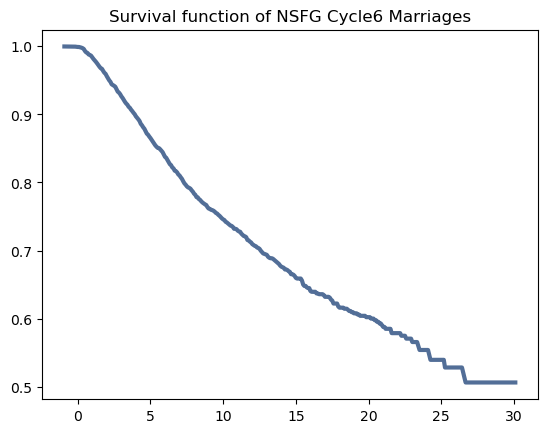

In [14]:
# As a sample using the married_cyc6 dataframe to plot the Survival function and Hazard function
hazard_func6, survival_func6=EstimateSurvival(married_cyc6)
thinkplot.Plot(survival_func6)
thinkplot.Config(loc="center right",title="Survival function of NSFG Cycle6 Marriages")

#### The curve is flat upto 2 years which means most marriages lasted upto 2 years and then they started to fizzle. surprisingly, the curve is flat after 27 years too indicating the marriages after 27 years mostly stayed strong and did not end up in divorces.

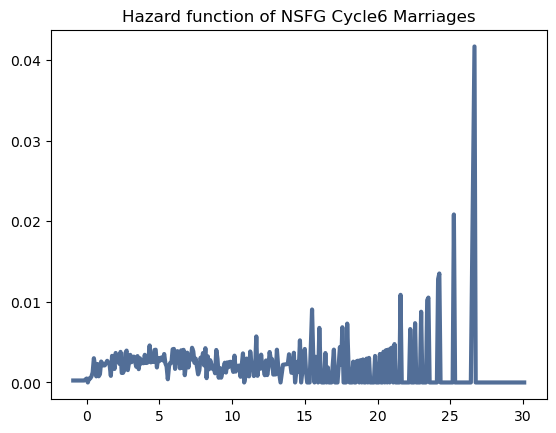

In [15]:
# Plotting Hazard function for married_cyc6 dataframe
thinkplot.Plot(hazard_func6)
thinkplot.Config(title="Hazard function of NSFG Cycle6 Marriages")

#### ***Question:*** Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

#### ***Solution:***  We create different samples using the weights for each Dataframe married_cyc6 and married_cyc7. Then all the samples are combined and the survival function is plot for each sample to find the sampling error.

In [16]:
def ResampleDivorceCurve(resps):
    """Plots divorce curves based on resampled data.
    resps: list of respondent DataFrames
    """
    # We iterate the process for upto 5 times
    for iterat in range(5):
        # For each iteration, we Resample the respondensts dataframe based on the weights and 
        # combine the sampled results
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        # All the sampled results are combined together and new index is generated
        samples_concat = pd.concat(samples, ignore_index=True)
        #For each sample, the Survival and Hazard function is calculated and plotted in the graph
        hazard_func,surv_func=EstimateSurvival(samples_concat,color="#225EA8")
        thinkplot.Plot(surv_func)
    # Plotting the dimensions 
    thinkplot.Config(xlabel="Years", ylabel="Fraction undivorced", axis=[0, 30, 0.4, 1],title="Survival Function from different samples")


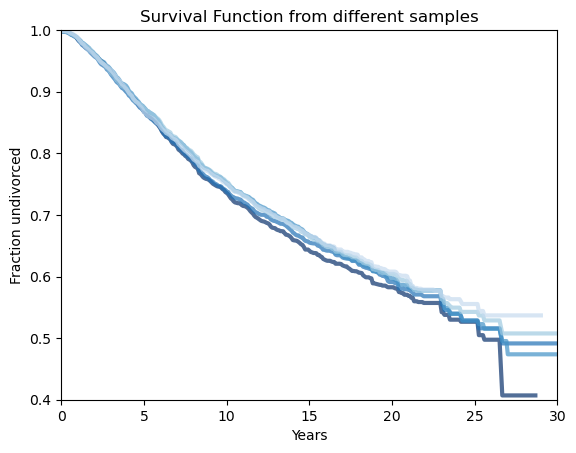

In [17]:
# Combining married_cyc6 and married_cyc6 to call ResampleDivorceCurve to plot Survival function 
# for each sample
resps=[married_cyc6,married_cyc7]
ResampleDivorceCurve(resps)


#### ***Interpretation of the plot:*** The Plot shows the sampling error from 5 different samples, most of them show similar pattern and the ifferences starts to show up between 15 to 20 years and the differences are more pronounced after 20 years between the samples.

#### ***Question:*** Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

#### ***Solution:*** We follow the same procedure as in the step above , but we group the samples based on the field decade which is derived from Century Birth month.  The results are then plotted.

In [18]:
def ResampleDivorceCurveByDecade(resps):
    """Plots divorce curves for each birth decade.
    resps: list of respondent DataFrames
    """
    # Resampling the Dataframe upto 50 iterations
    for i in range(50):
        # For each iteration dataframe is resampled based on Weights
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        # All the sampled results are combined together  and new index is generated
        samples_concat = pd.concat(samples, ignore_index=True)
        # The data is then grouped based on the Decade
        groups_decade = samples_concat.groupby("decade")
        # For the first iteration only add the label to the plot by calling AddLabelsByDecade function
        if i == 0:
            survival.AddLabelsByDecade(groups_decade, alpha=1)
        # This will compute the survival function for each grouped sample and plot the results
        EstimateSurvivalByDecade(groups_decade, alpha=0.1)
    # Plotting the dimensions 
    thinkplot.Config(xlabel="Years", ylabel="Fraction undivorced", axis=[0, 28, 0, 1])

In [19]:
def EstimateSurvivalByDecade(groups_decade, **options):
    """Groups respondents by decade and plots survival curves.
    groups_decade: GroupBy object
    """
    # Creating Preplot based on number of the groups(In this case we have 5 decades)
    thinkplot.PrePlot(len(groups_decade))
    # For each group, compute the survival function and plot it
    for name, group in groups_decade:
        # Calculating the Hazard and survival function for each group
        hazard_func , survive_func = EstimateSurvival(group)
        thinkplot.Plot(survive_func, **options)

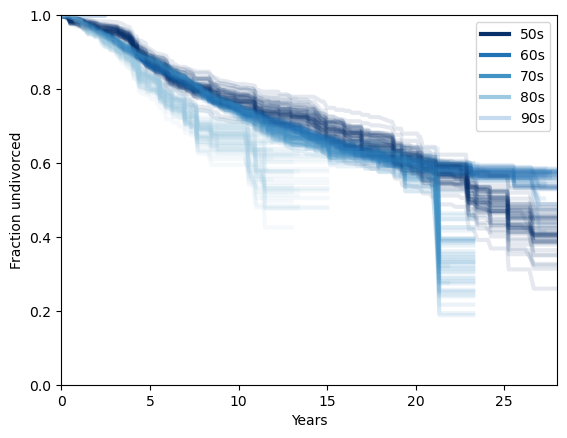

In [20]:
# Plot the resample data grouped by decade
ResampleDivorceCurveByDecade([married_cyc6, married_cyc7])

#### The Plot shows the women born in 50's remained undivorced longer than others for most number of years. More women from 60's remained married(undivorced) than compared to 70's. The Fraction of women staying married/undivorced keeps going down and we move through 80's and 90's, which indates more divorces in the women born recent decades than from the older generations.